# ML notebook
* Some notes are marked down below important figures
* Runtime about two minutes

## Import libraries and load dataset
Run this section only once per kernel instance. A copy of the original dataset is passed to the next section.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

In [2]:
# Takes half a minute to load
features_table = pd.read_csv(f"../data/hackathon/feature_table_by_quarter.csv") # Over a GB file size
# features_table = pd.read_csv(f"feature_table_by_quarter.csv") # Over a GB file size
features_table_bck = features_table.copy(deep=True)

/tmp/ipykernel_1855/885242323.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  features_table = pd.read_csv(f"../data/hackathon/feature_table_by_quarter.csv") # Over a GB file size


## Data pre-processing

Features ending with quarter0 are the target variables. Precedding features end with quarter1, quarter2...

Features (number 17 onwards) have a prefix d_ for download speed, u_ for upload speed, l_ for latency, t_ for tests.

In [3]:
features_table = features_table_bck.copy(deep=True)
for i, col in enumerate(features_table.columns):
    print(i,col)
# print(features_table.head())
# features_table.describe()

0 quadkey
1 PRNAME
2 CDNAME
3 CDTYPE
4 CSDNAME
5 CSDTYPE
6 ERNAME
7 SACTYPE
8 das_area
9 tile_area
10 tile_frac
11 das_frac
12 DAPOP
13 POP_DENSITY
14 PCNAME
15 PCTYPE
16 PCCLASS
17 d_quarter0
18 u_quarter0
19 l_quarter0
20 t_quarter0
21 d_quarter1
22 u_quarter1
23 l_quarter1
24 t_quarter1
25 d_quarter2
26 u_quarter2
27 l_quarter2
28 t_quarter2
29 d_quarter3
30 u_quarter3
31 l_quarter3
32 t_quarter3
33 d_quarter4
34 u_quarter4
35 l_quarter4
36 t_quarter4
37 d_quarter5
38 u_quarter5
39 l_quarter5
40 t_quarter5
41 d_quarter6
42 u_quarter6
43 l_quarter6
44 t_quarter6
45 d_quarter7
46 u_quarter7
47 l_quarter7
48 t_quarter7
49 d_quarter8
50 u_quarter8
51 l_quarter8
52 t_quarter8


In [4]:
pkey = 'quadkey'
#geometry = 'geometry'
id_and_names = ['DAUID', 'CDUID', 'CDNAME', 'CCSUID', 'CSDNAME', 'CMAUID', 'CMAPUID', 'CMANAME', 
'CCSNAME', 'CSDUID', 'ERUID', 'ERNAME', 'CTUID', 'CTNAME', 'ADAUID', 
'PCUID', 'PCNAME', 'PCPUID', 'SACCODE'] ##SACCODE is half a category half ID values

categorical_labels = [
    #'PRUID', #PRUID is redundant with PRNAME
    'CDNAME', 'CSDNAME',
    'PRNAME', 'CDTYPE', 
    'CSDTYPE',  
    'SACTYPE', 
    'PCNAME', 'PCTYPE', 'PCCLASS'
]
numerical_vars = [
    'das_area', 'tile_area', 'tile_frac',  'das_frac', 
    'DAPOP','POP_DENSITY'
]

down_cols = [col for col in features_table if col.startswith('d_quarter')]
up_cols = [col for col in features_table if col.startswith('u_quarter')]
lat_cols = [col for col in features_table if col.startswith('l_quarter')]
tests_cols = [col for col in features_table if col.startswith('t_quarter')]

ookla_vars = down_cols + up_cols + lat_cols +tests_cols

target_vars = ['d_quarter0', 'u_quarter0', 'l_quarter0', 't_quarter0']

ookla_vars = [col for col in ookla_vars if col not in target_vars]

In [5]:
col_subset = [pkey] + categorical_labels + numerical_vars + ookla_vars + target_vars
print(features_table.shape)
features_table = features_table.loc[:,col_subset].set_index('quadkey').dropna()
#print(features_table.isna().sum())
print(features_table.shape) # Compare with the previous shape to see how many rows/cols are dropped

(5235885, 53)
(531006, 51)


## ML model

In [6]:
from sklearn import preprocessing, pipeline, compose
from sklearn import linear_model, model_selection, svm
from sklearn import metrics

In [7]:
#Standard train/test where down and/or up speeds are the target/predicted continuous variable.
X_train, X_test, down_train, down_test = model_selection.train_test_split(
    features_table.drop(columns=target_vars), features_table['d_quarter0']
)

In [8]:
print(features_table.shape)
print(X_train.shape)
print(X_test.shape)
print(down_train.shape)
print(down_test.shape)

(531006, 51)
(398254, 47)
(132752, 47)
(398254,)
(132752,)


In [9]:
# Normalize the numerical Data and OneHot encode the categorical vars.
colTransformer = compose.ColumnTransformer(
    [(f"{cat}",preprocessing.OneHotEncoder(handle_unknown='ignore'),[cat]) for cat in categorical_labels] +\
    [(f"{num}", preprocessing.StandardScaler(), [num]) for num in numerical_vars] +\
    [(f"{num}", preprocessing.StandardScaler(), [num]) for num in ookla_vars]
    #+ [(f"{y}_stdscaler", preprocessing.StandardScaler(), [y]) for y in target_vars]
)

#Setup a regressor for predicting down speeds.
ridge = linear_model.RidgeCV()
regressor = compose.TransformedTargetRegressor(
    regressor=ridge,
    transformer=preprocessing.PowerTransformer(method='box-cox')
)

# Combine above in a reuseable pipeline object
pipe = pipeline.Pipeline([
    ('preprocess',colTransformer),
    ('regressor', regressor)
])

In [10]:
#train the model
pipe.fit(X_train, down_train) # Takes 100 seconds to fit

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('CDNAME',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CDNAME']),
                                                 ('CSDNAME',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CSDNAME']),
                                                 ('PRNAME',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PRNAME']),
                                                 ('CDTYPE',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CDTYPE']),
                                                 ('CSDTYPE',
                                                  OneHotEncoder(handle_unknown='i...
                                                 ('u_quarter3',
                                                  StandardScaler(),
                                                  ['u_quarter3']),
                                                 ('u_quarter4',
                                                  StandardScaler(),
                                                  ['u_quarter4']),
                                                 ('u_quarter5',
                                                  StandardScaler(),
                                                  ['u_quarter5']),
                                                 ('u_quarter6',
                                                  StandardScaler(),
                                                  ['u_quarter6']),
                                                 ('u_quarter7',
                                                  StandardScaler(),
                                                  ['u_quarter7']), ...])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RidgeCV(),
                                            transformer=PowerTransformer(method='box-cox')))])

## ML results

In [11]:
# how did it do on the training set
# speeds are in kbps
{"Mean Absolute Error":metrics.mean_absolute_error(pipe.predict(X_train), down_train),
"Median Absolute Error":metrics.median_absolute_error(pipe.predict(X_train), down_train),
"Mean Absolute Percentage Error":metrics.mean_absolute_percentage_error(pipe.predict(X_train), down_train)}

{'Mean Absolute Error': 55353.30929964433,
 'Median Absolute Error': 41288.89742695942,
 'Mean Absolute Percentage Error': 0.33022430194300834}

* Gives low percentage error, but the predictions are normally distributed.
* Input data is normally distributed as well.

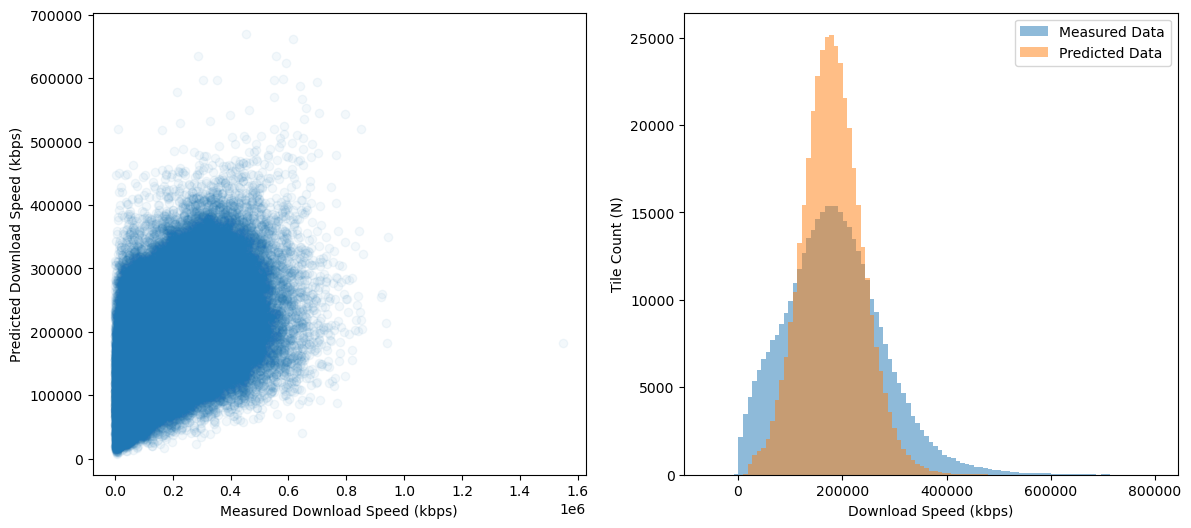

In [12]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].scatter(down_train, pipe.predict(X_train), alpha=0.05);
axs[0].set(xlabel="Measured Download Speed (kbps)", ylabel="Predicted Download Speed (kbps)");

bins = np.linspace(-60000,800000,100)
axs[1].hist(down_train,alpha=0.5, bins=bins,label='Measured Data')
axs[1].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='Predicted Data');
axs[1].legend()
axs[1].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

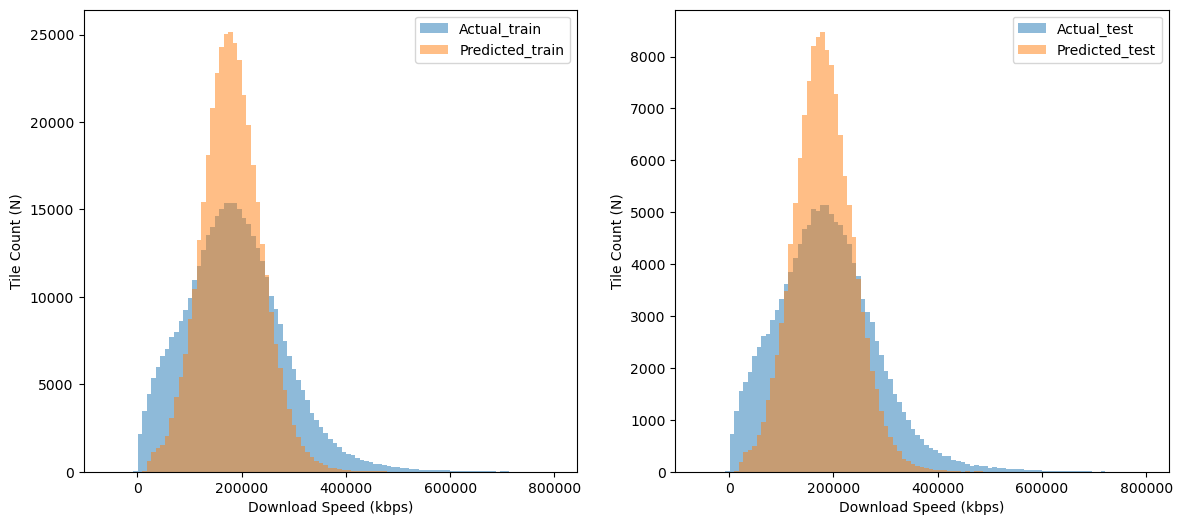

In [13]:
fig, axs = plt.subplots(1,2, figsize=(14,6))

bins = np.linspace(-60000,800000,100)
axs[0].hist(down_train,alpha=0.5, bins=bins,label='Actual_train')
axs[0].hist(pipe.predict(X_train),alpha=0.5, bins=bins,label='Predicted_train');
axs[0].legend()
axs[0].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

bins = np.linspace(-60000,800000,100)
axs[1].hist(down_test,alpha=0.5, bins=bins,label='Actual_test')
axs[1].hist(pipe.predict(X_test),alpha=0.5, bins=bins,label='Predicted_test');
axs[1].legend()
axs[1].set(xlabel='Download Speed (kbps)', ylabel='Tile Count (N)');

<Axes: >

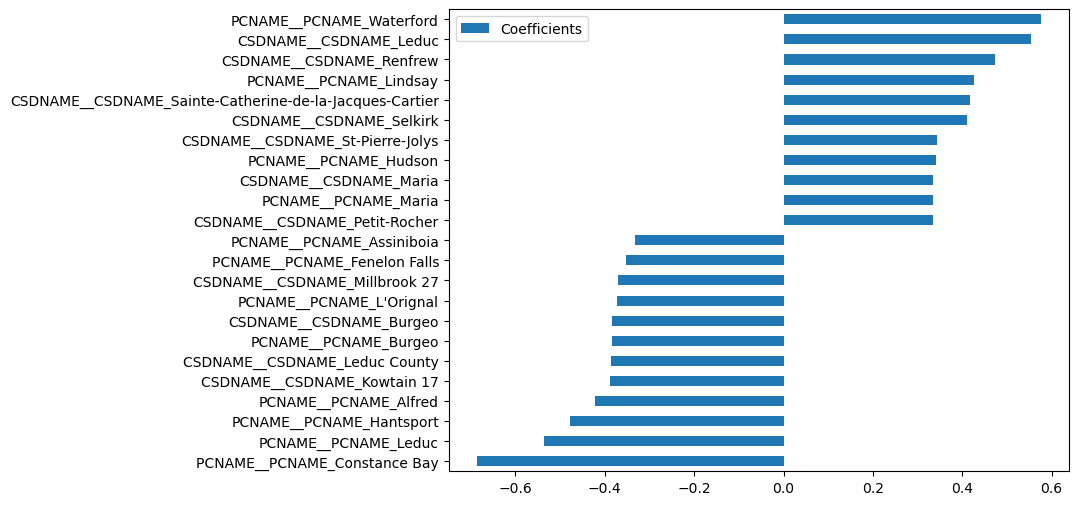

In [14]:
# What are the important coefficients.
coefs = pd.DataFrame(pipe[-1].regressor_.coef_,columns=['Coefficients'],index=pipe[:-1].get_feature_names_out())
coefs = coefs[np.abs(coefs.values) > 0.33]
coefs.sort_values(by='Coefficients').plot.barh(figsize=(8,6))

* Some categorical features cancel each other out.
* Why no speed column has high coefficient?

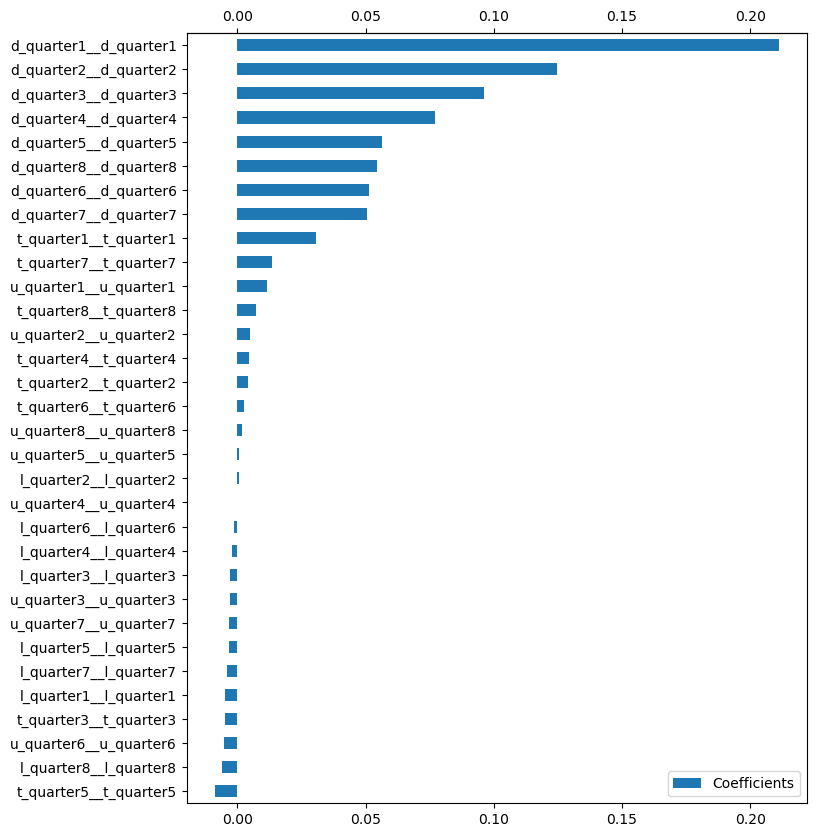

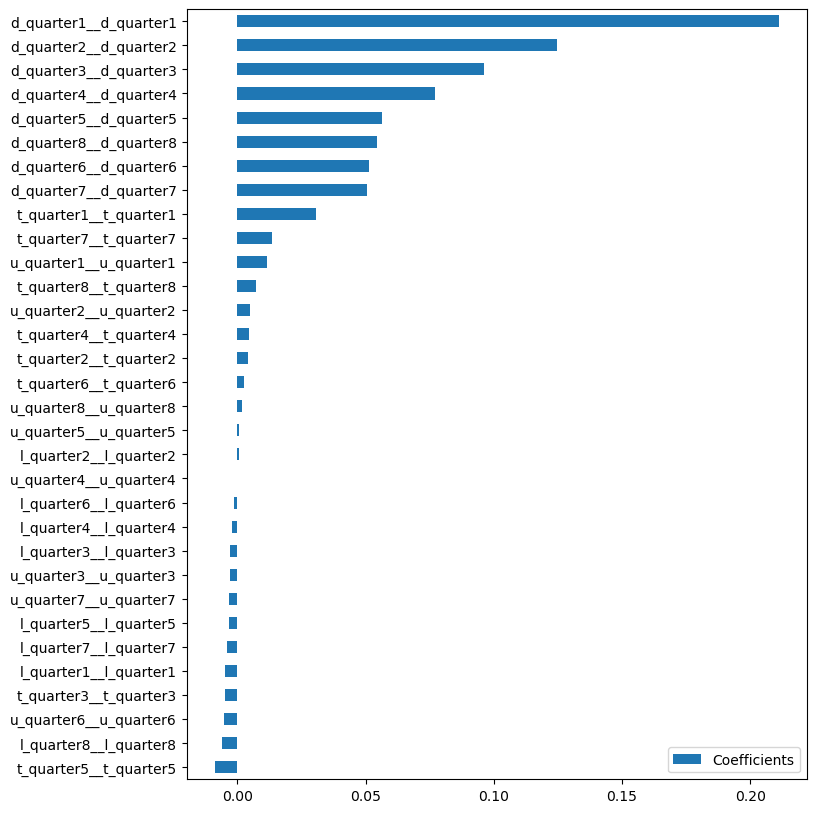

In [15]:
# What about the previous year speed data.
coefs = pd.DataFrame(pipe[-1].regressor_.coef_,columns=['Coefficients'],index=pipe[:-1].get_feature_names_out())
coefs = coefs[coefs.index.isin([f"{col}__{col}" for col in ookla_vars])]
ax = coefs.sort_values(by='Coefficients').plot.barh(figsize=(8,10))
ax2 = ax.secondary_xaxis('top')
ax2 = coefs.sort_values(by='Coefficients').plot.barh(figsize=(8,10))

In [16]:
coefs

,Coefficients
d_quarter1__d_quarter1,0.211061
d_quarter2__d_quarter2,0.124727
d_quarter3__d_quarter3,0.096170
d_quarter4__d_quarter4,0.077028
d_quarter5__d_quarter5,0.056514
d_quarter6__d_quarter6,0.051302
d_quarter7__d_quarter7,0.050358
d_quarter8__d_quarter8,0.054412
u_quarter1__u_quarter1,0.011455
u_quarter2__u_quarter2,0.004746


* The model has indeed learned stuff
    * Uses previous download speeds to predict future download speeds
    * The most recent data is evaluated more important